In [2]:
"""
python实现的东方财富网站股票数据爬取
但因为官网数据是用JS渲染出来的，没法直接爬取

我用的方法是去后台查json文件，然后找到包含股票数据的url链接，然后使用正则匹配出数据的
（是用来训练模型的）

也可以试试用selenium来实现，看看能不能获取到数据
Ciallo～(∠・ω< )⌒☆

"""

import re
import requests
import json
import pandas as pd

url = 'https://push2his.eastmoney.com/api/qt/stock/kline/get?cb=jQuery351016702133557143928_1757311398446&secid=1.000300&ut=fa5fd1943c7b386f172d6893dbfba10b&fields1=f1%2Cf2%2Cf3%2Cf4%2Cf5%2Cf6&fields2=f51%2Cf52%2Cf53%2Cf54%2Cf55%2Cf56%2Cf57%2Cf58%2Cf59%2Cf60%2Cf61&klt=101&fqt=1&beg=0&end=20500101&smplmt=460&lmt=1000000&_=1757311398447'

repsonse = requests.get(url)
text = repsonse.text


# 数据示例
"""
jQuery35109392514059566558_1756826314307({"rc":0,"rt":17,"svr":181669694,"lt":1,"full":0,"dlmkts":"","data":{"code":"000300","market":1,"name":"沪深300","decimal":2,"dktotal":5021,"preKPrice":3941.42,"klines":["2025-03-12,3946.86,3927.23,3953.61,3921.47,156732190,309627267364.80,0.82,-0.36,-14.19,0.48","2025-03-13,3925.74,3911.58,3939.29,3897.38,
"""

# 提取 JSON 数据 // 因为内部有括号，所以用正则匹配先去除掉里面的括号
match = re.search(r'\((\{.*\})\)', text)

json_str = match.group(1) # 获取括号中的内容
data = json.loads(json_str) # 将字符串转为字典

gupiao_name = data['data']['name']
gupiao_size = len(data['data']['klines'])

print(gupiao_name, gupiao_size)

# for line in data['data']['klines']:
#     print(line.split(','))

data = [line.split(',') for line in data['data']['klines']]

# pd.save_csv(f'{gupiao_name}-{gupiao_size}.csv', index=False)

data = pd.DataFrame(data)
data.head()


沪深300 460


,0,1,2,3,4,5,6,7,8,9,10
0,2005-01-04,994.77,982.79,994.77,980.66,7412868,4431977400.00,0.00,0.00,0.00,0.02
1,2005-01-19,974.33,967.21,974.33,965.26,6338091,3427951300.00,0.93,-0.77,-7.48,0.02
2,2005-02-03,1005.56,993.22,1014.19,992.16,16974539,10057310300.00,2.19,-1.36,-13.69,0.05
3,2005-03-01,1039.35,1035.93,1042.74,1031.17,9962090,6288790700.00,1.11,-0.39,-4.06,0.03
4,2005-03-16,1011.85,1003.07,1012.20,995.97,10622782,7153745900.00,1.60,-1.03,-10.45,0.03


In [26]:
import numpy as np

raw_df = pd.read_csv(f"{gupiao_name}-460.csv")

# 数据分为多行显示，每行包含不完整的记录，需要合并两行才能形成完整的记录
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :]]) # 去除掉date从第2列开始的重复数据
target = raw_df.values[::2, 2] # 获取从0开始，每隔2行取数据，即获取第1列数据

# 将数据分开，分别为data训练集和target测试集
data.shape, target.shape


((115, 20), (115,))

In [27]:
"""
date: 日期
open: 开盘价
close: 收盘价
high: 最高价
low: 最低价
volume: 成交量
amount: 成交额
amplitude: 振幅
change_pct: 涨跌幅
change_val: 涨跌额
turnover: 换手率
"""

import pandas as pd
import numpy as np

complete_data = np.column_stack([data, target])[:, :10] # 拼接数据，由于数据量较大，所以只取前10列
columns = ["open", "close", "high", "low", "volume", "amount", "amplitude", "change_pct", "change_val", "turnover"]


df = pd.DataFrame(complete_data, columns=columns)
df


# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)
# df.to_csv(f'{gupiao_name}-{gupiao_size}.csv', index=False)


# data = pd.read_csv(f'{gupiao_name}-{gupiao_size}.csv')


,open,close,high,low,volume,amount,amplitude,change_pct,change_val,turnover
0,982.79,994.77,980.66,7412868.0,4.431977e+09,0.00,0.00,0.00,0.02,974.33
1,1003.07,1012.20,995.97,10622782.0,7.153746e+09,1.60,-1.03,-10.45,0.03,934.85
2,868.46,871.77,855.59,9206929.0,4.777972e+09,1.87,0.59,5.12,0.03,848.54
3,856.86,860.95,854.28,11816080.0,5.762385e+09,0.78,-0.33,-2.83,0.04,926.97
4,916.15,927.42,914.81,11547644.0,5.549882e+09,1.37,-0.77,-7.12,0.04,903.27
...,...,...,...,...,...,...,...,...,...,...
110,4024.28,4091.70,4002.50,335807938.0,6.391241e+11,2.21,-0.50,-20.29,1.03,3979.46
111,3789.22,3810.74,3731.19,169166968.0,3.009657e+11,2.10,-0.18,-6.89,0.52,3829.05
112,4010.17,4025.30,3989.51,144419428.0,2.860753e+11,0.89,0.06,2.45,0.44,3843.42
113,3860.11,3884.54,3849.04,109601207.0,2.088768e+11,0.91,-0.57,-22.16,0.34,3870.67


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        115 non-null    float64
 1   close       115 non-null    float64
 2   high        115 non-null    float64
 3   low         115 non-null    float64
 4   volume      115 non-null    float64
 5   amount      115 non-null    float64
 6   amplitude   115 non-null    float64
 7   change_pct  115 non-null    float64
 8   change_val  115 non-null    float64
 9   turnover    115 non-null    float64
dtypes: float64(10)
memory usage: 9.1 KB


In [29]:
df.describe()

,open,close,high,low,volume,amount,amplitude,change_pct,change_val,turnover
count,115.000000,115.000000,115.000000,1.150000e+02,1.150000e+02,115.000000,115.000000,115.000000,115.000000,115.000000
mean,3247.416696,3275.128870,3216.393739,1.076633e+08,1.538350e+11,1.801652,-0.007565,-1.148435,0.329304,3258.150522
std,1077.657086,1086.133627,1068.129059,8.976957e+07,1.421453e+11,1.298280,1.679152,52.717025,0.274717,1073.726396
min,856.860000,860.950000,854.280000,7.412868e+06,3.676845e+09,0.000000,-7.100000,-232.600000,0.020000,848.540000
25%,2539.665000,2555.220000,2508.520000,5.466053e+07,6.046827e+10,0.930000,-0.570000,-18.220000,0.170000,2510.260000
50%,3366.710000,3390.010000,3339.550000,8.922628e+07,1.101328e+11,1.400000,-0.070000,-1.980000,0.270000,3407.000000
75%,3965.345000,3965.695000,3917.975000,1.383883e+08,2.098876e+11,2.085000,0.785000,23.005000,0.425000,3877.240000
max,5518.520000,5541.460000,5410.780000,4.903150e+08,6.853650e+11,6.570000,6.680000,164.880000,1.500000,5695.130000


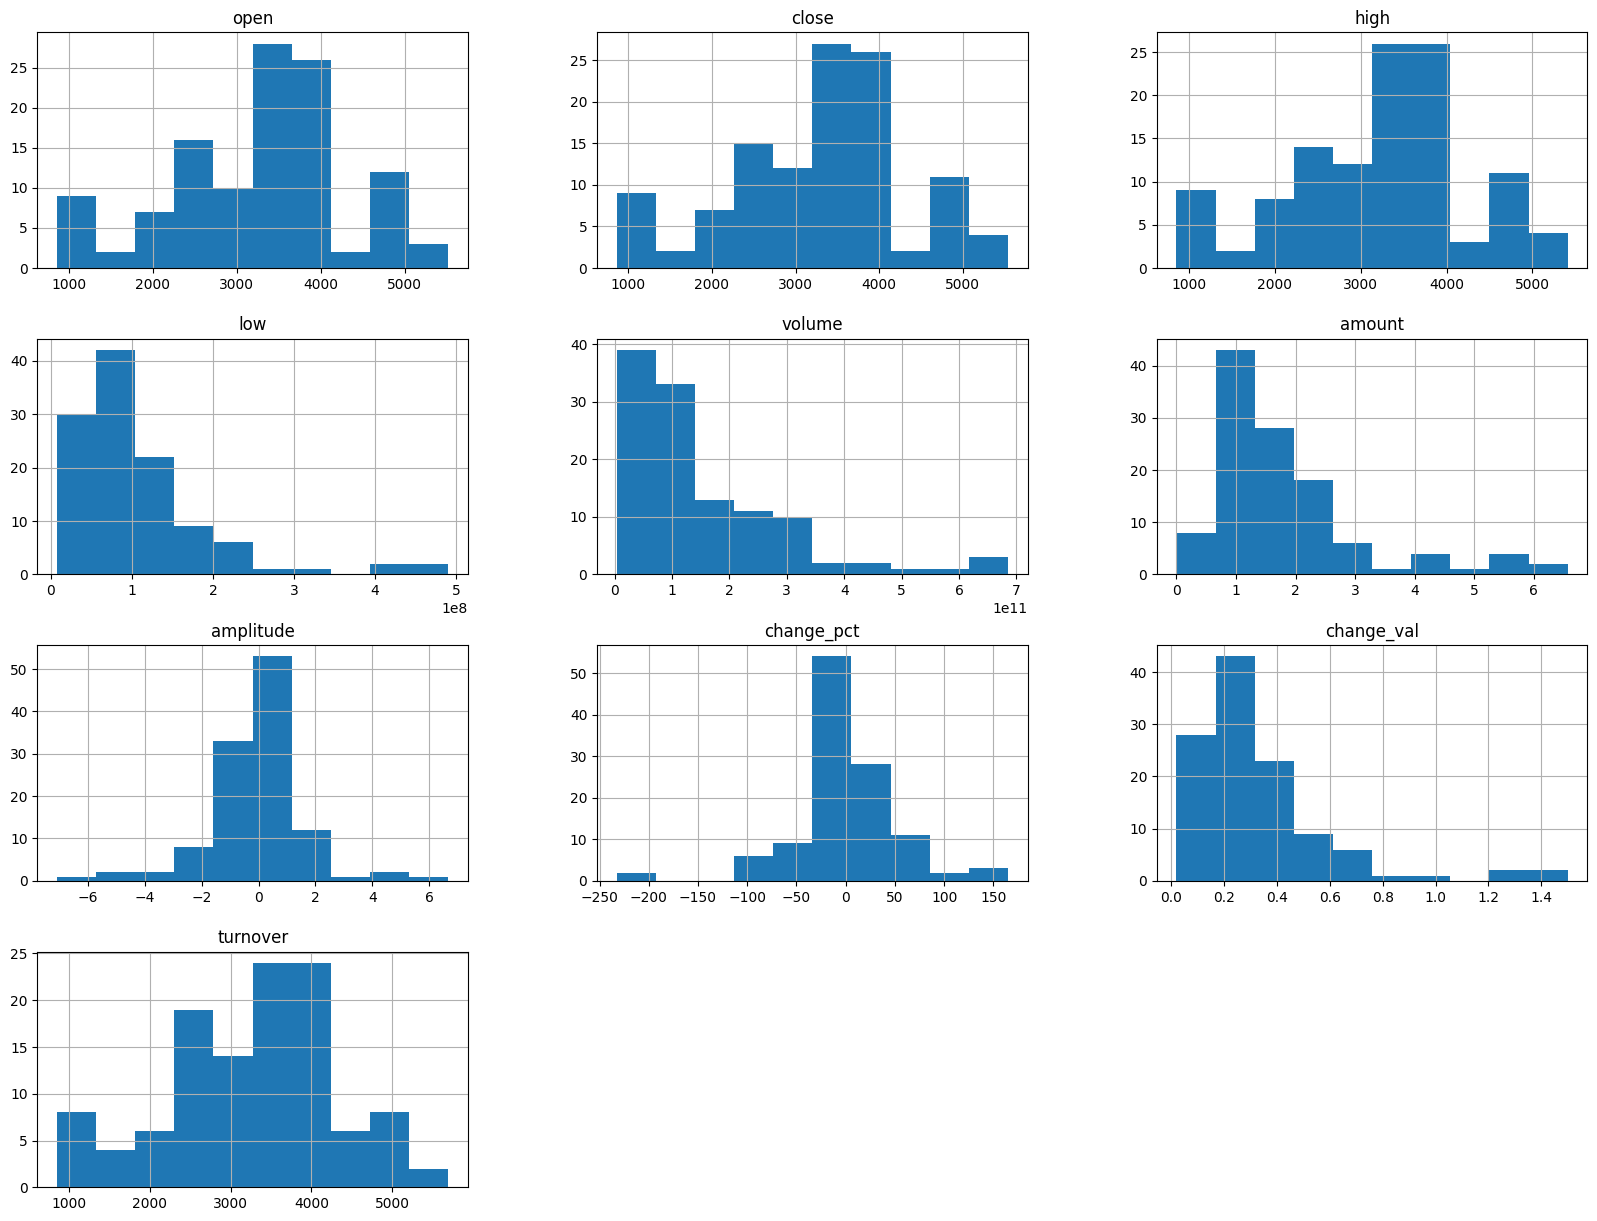

In [30]:
import matplotlib.pyplot as plt


df.hist(bins=10, figsize=(20, 15))
plt.show()

In [31]:
# 绘制各个特征的房价的关系
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [32]:
correlation_marix = df.corr() # corr() 是 Pandas 库中的一个函数，用于计算 DataFrame 中所有列之间的相关系数矩阵。相关系数矩阵是一个对称矩阵，其中每个元素表示两个变量之间的相关系数。相关系数的取值范围为 [-1, 1]，其中 -1 表示完全负相关，1 表示完全正相关，0 表示不相关。

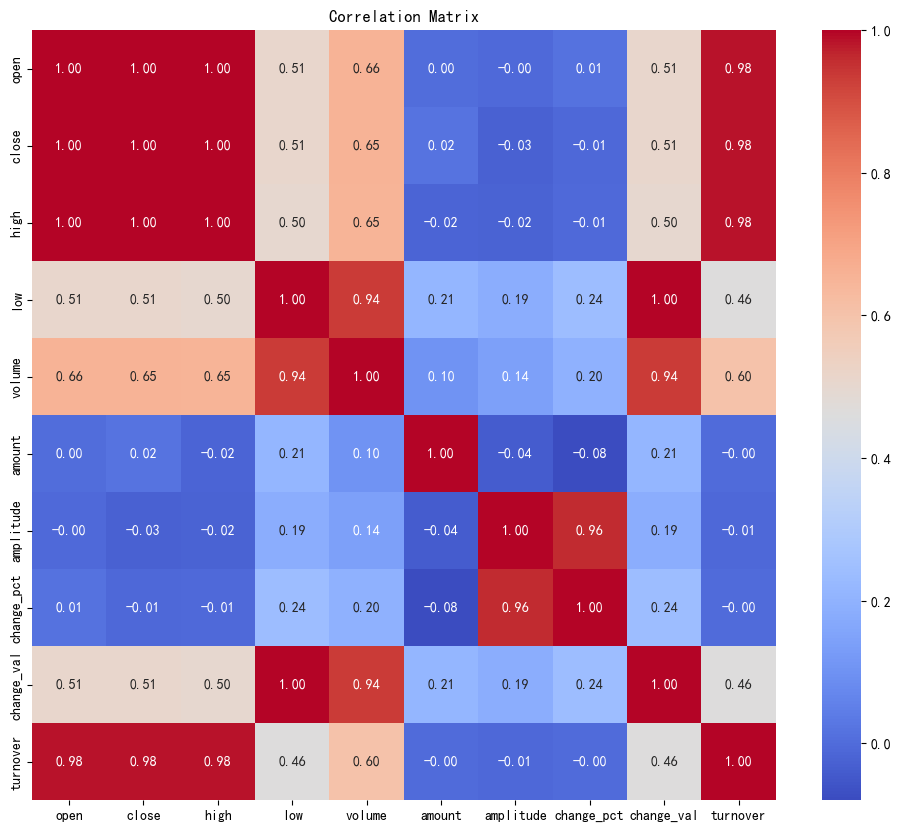

In [33]:
# 可视化相关矩阵
plt.figure(figsize=(12, 10)) # 设置图片大小
sns.heatmap(correlation_marix, annot=True, fmt=".2f", cmap="coolwarm") # 说明：annot=True表示在每个单元格中显示数值，fmt=".2f"表示保留两位小数，cmap="coolwarm"表示颜色映射
plt.title("Correlation Matrix") # 标题
plt.show() # 显示图片


In [34]:
from sklearn.linear_model import LinearRegression # 线性回归模型
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('./沪深300-460_date.csv')
# 将日期转换为时间戳
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].map(pd.Timestamp.toordinal)

X = df.drop(columns='close', axis=1)
y = df['close']
print(X)
print(y)

# 创建线性回归模型
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 随机种子 // 保证每次运行结果一致

model.fit(X_train, y_train) # 训练模型
print(f'权重w0：{model.intercept_}') # 截距
print(f'系数w1：{model.coef_}') # 系数

# 模型预测，传入测试集
y_pred = model.predict(X_test) # 预测结果
print(f'预测结果：{y_pred}')
mse = mean_squared_error(y_test, y_pred)
print(f'均方误差MSE：{mse}')
r2 = r2_score(y_test, y_pred)
print(f'R2系数：{r2}')


       date     open     high      low     volume        amount  amplitude  \
0    731950   994.77   994.77   980.66    7412868  4.431977e+09       0.00   
1    731965   974.33   974.33   965.26    6338091  3.427951e+09       0.93   
2    731980  1005.56  1014.19   992.16   16974539  1.005731e+10       2.19   
3    732006  1039.35  1042.74  1031.17    9962090  6.288791e+09       1.11   
4    732021  1011.85  1012.20   995.97   10622782  7.153746e+09       1.60   
..      ...      ...      ...      ...        ...           ...        ...   
455  739442  3993.42  4032.98  3992.52  209778904  3.478367e+11       1.01   
456  739457  4145.32  4150.50  4117.80  273594963  4.304455e+11       0.79   
457  739474  4110.29  4134.25  4103.61  190443716  3.606858e+11       0.75   
458  739489  4453.35  4476.80  4435.53  270621395  6.279505e+11       0.92   
459  739502  4467.17  4482.76  4438.07  213298875  5.799364e+11       1.00   

     change_pct  change_val  turnover  
0          0.00        

In [35]:
y_test, y_pred

(124    2850.83
 30     1317.65
 199    2303.48
 439    3957.78
 154    2477.69
         ...   
 299    3531.11
 46     2298.00
 101    3667.56
 415    3736.65
 157    2504.32
 Name: close, Length: 92, dtype: float64,
 array([2845.35357832, 1317.92153915, 2310.88210542, 3947.02870216,
        2478.38580487, 3526.76457135, 4097.1883211 , 3860.46938553,
        3633.14928031, 3690.97818044, 3851.61570932, 3998.07885838,
        2977.08421268, 4056.69045756, 3176.21310519, 3464.02040141,
        2165.95915445, 3098.66153155, 3898.97680195,  989.28176215,
        4631.76824177, 3352.41224573, 3299.5610373 , 1430.36218164,
        2167.10081103, 3402.15766724, 3751.40231321, 2090.50023765,
        2983.01099189,  906.6769567 , 3560.21417714, 5220.34427914,
        3955.39588233, 3850.23458939, 4616.74805442, 3837.54017958,
        3824.72790723, 3189.20538734, 2790.12201624, 3834.14870626,
        3663.39984454, 4171.41027739, 2366.01862674, 2879.41073133,
        3381.80248504, 3179.559690

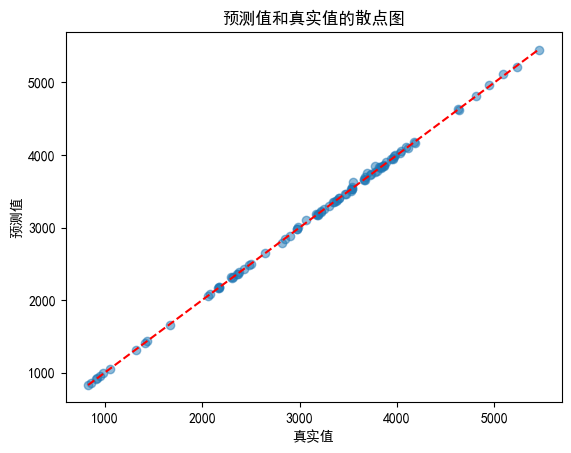

In [36]:
plt.scatter(y_test, y_pred, alpha=0.5) # 绘制预测值和真实值的散点图 // y_test 表示真实值, y_pred 表示预测值
plt.xlabel("真实值") # 添加 x 轴标签
plt.ylabel("预测值") # 添加 y 轴标签
plt.title("预测值和真实值的散点图") # 添加标题
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') # 绘制对角线
plt.show() # 显示图像

我大概看明白了，你现在是拿一个股票数据表（沪深300）做线性回归，用日期、开盘价、高低点、成交量这些当特征，预测收盘价对吧？

你跑出来的结果里：

* **MSE 只有 331**（相对几千点的收盘价来说，误差特别小）
* **R² 系数 0.9997**（几乎完美拟合）

这基本上说明 \*\*线性回归已经“过拟合”\*\*了。为什么？

因为你在训练的时候，用了很多和收盘价高度相关的特征（比如当天的开盘价、高点、低点，几乎和收盘价是强相关的）。模型相当于“看答案抄答案”，当然拟合得特别好，但实际上如果你要预测未来的数据（真正未知的收盘价），它就不一定能保持这么高的准确度。

---

要进一步学习/改进，可以有几个方向：

1. **严格划分时间顺序**

   * 不能随机打乱拆分（train\_test\_split 会打乱），这样测试集可能包含比训练集还早的数据。
   * 股票预测必须用「过去 → 未来」的方式，比如前 80% 数据做训练，后 20% 数据做测试。

   ```python
   train_size = int(len(df) * 0.8)
   X_train, X_test = X[:train_size], X[train_size:]
   y_train, y_test = y[:train_size], y[train_size:]
   ```

2. **减少“泄漏特征”**

   * 如果你想预测明天的收盘价，不能用当天的「开盘价、高点、低点」去预测，因为这些数本来就是当天收盘价的函数。
   * 更合理的方法是只用「过去的收盘价、成交量、涨跌幅等滞后特征」来预测。
   * 举个例子，可以构造 `close(t-1), close(t-2), ...` 作为特征，预测 `close(t)`。

3. **尝试非线性模型**

   * 股票这种数据往往不是线性的，可以试试：

     * `RandomForestRegressor`
     * `GradientBoostingRegressor`
     * `XGBoost`
     * 或者简单的神经网络（MLP）

4. **尝试时间序列方法**

   * ARIMA、Prophet
   * LSTM、GRU 这类循环神经网络

---

我猜你现在的疑问是：**如果我想用神经网络替换掉这个线性回归，是不是只要把 `LinearRegression()` 换成 `MLPRegressor()` 就行？**

答案是：几乎可以。只要注意输入数据要标准化（神经网络训练对数值大小敏感）。

要不要我帮你直接把你这份 `LinearRegression` 的代码改成 **MLP 神经网络**的版本？


In [4]:
"""
这里做了几个关键改动：
数据标准化：神经网络必须做，否则数值差异太大，训练会很慢甚至不收敛。
时间序列切分：用前 80% 数据训练，后 20% 测试，更符合股票预测逻辑。
MLP 模型结构：两层隐藏层，分别 64、32 个神经元，可以自己调整。
训练参数：max_iter=500 保证能收敛，学习率也可以尝试调小或调大。
"""

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# 读取数据
df = pd.read_csv('./沪深300-460_date.csv')

# 将日期转为时间戳数值
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].map(pd.Timestamp.toordinal)

# 特征和目标
X = df.drop(columns='close', axis=1)
y = df['close']

# 数据标准化（神经网络很敏感，一定要做）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 按时间顺序划分训练/测试集（避免未来数据泄漏到训练中）
train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 定义 MLP 神经网络
model = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # 两层隐藏层，64 和 32 个神经元
    activation='relu',            # 激活函数 ReLU
    solver='adam',                # 优化器 Adam
    learning_rate_init=0.001,     # 学习率
    max_iter=500,                 # 最大迭代次数
    random_state=42
    ,verbose=True
)

# 训练模型
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估
mse = mean_squared_error(y_test, y_pred) # MSE 均方误差数学描述：预测值和真实值之间的差异的平方 y=预测值-真实值 ** 2
r2 = r2_score(y_test, y_pred) # R2 系数数学描述：预测值和真实值之间的差异的比例 1-（预测值和真实值之间的差异的平方和）/（真实值和真实值的平均值的差异的平方和）

print(f'均方误差MSE：{mse:.2f}')
print(f'R2系数：{r2:.4f}')
print(f'预测结果（部分）：{y_pred[:10]}')


Iteration 1, loss = 5377501.14696864
Iteration 2, loss = 5377108.62327309
Iteration 3, loss = 5376706.34591609
Iteration 4, loss = 5376295.04999931
Iteration 5, loss = 5375860.87395796
Iteration 6, loss = 5375419.05133950
Iteration 7, loss = 5374956.28796807
Iteration 8, loss = 5374473.20229450
Iteration 9, loss = 5373954.40220788
Iteration 10, loss = 5373428.46542244
Iteration 11, loss = 5372853.03690882
Iteration 12, loss = 5372263.15923881
Iteration 13, loss = 5371615.03524480
Iteration 14, loss = 5370938.61114209
Iteration 15, loss = 5370234.49747850
Iteration 16, loss = 5369470.34125909
Iteration 17, loss = 5368676.29503956
Iteration 18, loss = 5367826.17078367
Iteration 19, loss = 5366922.08502170
Iteration 20, loss = 5365973.74416742
Iteration 21, loss = 5364966.49722544
Iteration 22, loss = 5363875.81553897
Iteration 23, loss = 5362718.01325232
Iteration 24, loss = 5361505.73243219
Iteration 25, loss = 5360191.42956958
Iteration 26, loss = 5358801.74866545
Iteration 27, loss = 

c:\Users\16673\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


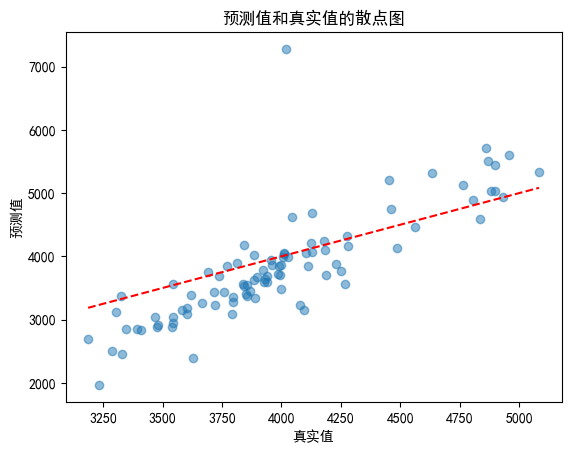

In [45]:
plt.scatter(y_test, y_pred, alpha=0.5) # 绘制预测值和真实值的散点图 // y_test 表示真实值, y_pred 表示预测值
plt.xlabel("真实值") # 添加 x 轴标签
plt.ylabel("预测值") # 添加 y 轴标签
plt.title("预测值和真实值的散点图") # 添加标题
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') # 绘制对角线
plt.show() # 显示图像

不是你设置的 🙂，出现 10 个结果是因为我在代码最后写了：

```python
print(f'预测结果（部分）：{y_pred[:10]}')
```

这里的 `y_pred[:10]` 只是**截取预测结果的前 10 个样本**来展示，方便你看。
实际上 `y_pred` 里面的结果数量 = 测试集的样本数量 (`X_test.shape[0]`)。

---

所以：

* 如果你的测试集有 92 天（比如总共 460 天，训练 368 天，测试 92 天），那么 `y_pred` 其实就是 92 个预测结果。
* 我只是用了 `[:10]` 让输出简短，不然一长串结果会刷屏。

---

如果你想看到所有预测值，可以直接打印：

```python
print(y_pred)
```

如果你只想预测**下一天的收盘价**，就不能直接用 `train_test_split`，需要写一个「滑动窗口」或者「递归预测」的方法，让模型根据最近几天的特征去预测未来一天。

要不要我给你写一个「专门预测下一天收盘价」的神经网络版本？


很好，这里我们就把「思路」讲清楚：为什么现在的代码预测一大堆，而你想要的是“下一天收盘价”。

---

### 1. 为什么现在是多个预测值？

因为你用了 `train_test_split`：

* 它把数据分成训练集（比如 80%）和测试集（20%）。
* 模型训练好后，对**测试集里的所有样本**都进行预测。
  所以预测结果自然有几十个、上百个。

---

### 2. 如果只想预测「下一天收盘价」该怎么做？

要让模型学会“根据过去的数据预测未来”，思路是这样的：

**核心：滑动窗口（Window）**

* 用最近 N 天的特征 → 预测第 N+1 天的收盘价。
* 例如：

  * 输入：\[3900, 3910, 3920] → 输出：3930
  * 输入：\[3910, 3920, 3930] → 输出：3940

这样模型学的就是「连续时间序列」的规律。

---

### 3. 实现步骤

1. **准备数据**
   把原始收盘价序列 `[3911, 4006, 3996, 4007, …]` 转换成「输入窗口 + 输出」对。

   * 输入窗口大小可以设 5 天、10 天等。
   * 例如窗口大小 = 5：

     * X1 = \[3911, 4006, 3996, 4007, 4010]，y1 = 4020
     * X2 = \[4006, 3996, 4007, 4010, 4020]，y2 = 4035

2. **划分训练和测试集**
   不用 `train_test_split` 随机划分，而是用**前 80% 时间做训练，最后 20% 时间做测试**。
   因为时间序列不能乱打乱。

3. **建模**

   * 可以用神经网络（MLPRegressor 或 keras/tf）
   * 输入是「过去 N 天的收盘价」，输出是「下一天收盘价」。

4. **预测**

   * 模型训练好以后，把最近 N 天的收盘价作为输入，预测未来 1 天。
   * 如果想预测多天，就用「递归预测」：预测明天 → 把预测值加到数据里 → 预测后天 → …

---

### 4. 整体逻辑图

```
原始序列: [3911, 4006, 3996, 4007, 4010, 4020, …]

↓ 构造窗口
X = [[3911, 4006, 3996, 4007, 4010],
     [4006, 3996, 4007, 4010, 4020],
     ...]
y = [4020, 4035, …]

↓ 训练模型
输入: X (过去N天) → 输出: y (下一天)

↓ 预测
最近N天输入模型 → 预测未来收盘价
```

---

要不要我帮你写一个**滑动窗口+神经网络**的完整代码，你只要把你的收盘价 `df['close']` 塞进去，就能直接跑出来预测「下一天收盘价」？


In [3]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor          # MLP 多层感知机回归器
from sklearn.metrics import mean_squared_error, r2_score # 均方误差，R2 系数

df = pd.read_csv('./沪深300-460_date.csv')

# 将日期转换为时间戳
df['date'] = pd.to_datetime(df['date']) # 将日期列转换为日期时间格式
df['date'] = df['date'].map(pd.Timestamp.toordinal) # toordinal() 将日期转换为时间戳

# print(df.head())

# ========= 1. 构造数据 =========
# 假设你已经有收盘价序列
# 例如：df = pd.read_csv('沪深300.csv')
# 收盘价放在 close 列
close_prices = df['close'].values
# print(close_prices)

# 滑动窗口大小（比如用过去 5天 预测第 6天）
windows_size = 5

X, y = [], []
for i in range(len(close_prices) - windows_size):
    X.append(close_prices[i:i+windows_size]) # 输入：过去 5天
    y.append(close_prices[i+windows_size]) # 输出：第 6天


# 转换为numpy数组用于训练
X = np.array(X)
y = np.array(y)

# ========= 2. 划分训练/测试集 =========
# 用前 80% split 训练集，后 20% 测试集
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

# ========= 3. 建立神经网络模型 =========
model = MLPRegressor(
    hidden_layer_sizes=(64, 32), # 两层隐藏层，每层 64 个神经元，32 个神经元，输入层64 输出层32
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    verbose=True # 显示训练过程
)
print(model) # 查看模型参数

# 训练
model.fit(X_train, y_train)

# ========= 4. 测试集评估 =========
y_pred = model.predict(X_test) # 用测试集输入预测输出

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'均方误差: {mse:.2f}')
print(f'R2 系数: {r2:.4f}')

# ========= 5. 预测未来一天 =========
last_window = close_prices[-windows_size:] # 最近的 5 天
next_day_pred = model.predict([last_window])
print(f'预测下一天的预测收盘价: {next_day_pred[0]:.2f}')

# print(y_test, y_pred) # 查看测试集的真实值和预测值


364 91
364 91
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42,
             verbose=True)
Iteration 1, loss = 6623150.27718970
Iteration 2, loss = 5683819.74843681
Iteration 3, loss = 4840240.95648641
Iteration 4, loss = 4077134.47699016
Iteration 5, loss = 3501504.94184522
Iteration 6, loss = 3038340.88855604
Iteration 7, loss = 2639779.63986517
Iteration 8, loss = 2260414.39220743
Iteration 9, loss = 1926478.25073614
Iteration 10, loss = 1625231.20208631
Iteration 11, loss = 1352472.52679318
Iteration 12, loss = 1108848.95637189
Iteration 13, loss = 893802.93839839
Iteration 14, loss = 707224.43781987
Iteration 15, loss = 565325.34933557
Iteration 16, loss = 444150.78699448
Iteration 17, loss = 342886.73542210
Iteration 18, loss = 258577.67570186
Iteration 19, loss = 187416.02759650
Iteration 20, loss = 128647.91325167
Iteration 21, loss = 87660.59678560
Iteration 22, loss = 65544.77428356
Iteration 23, loss = 58107.58205564
Iteration 24, loss = 62851.9842762

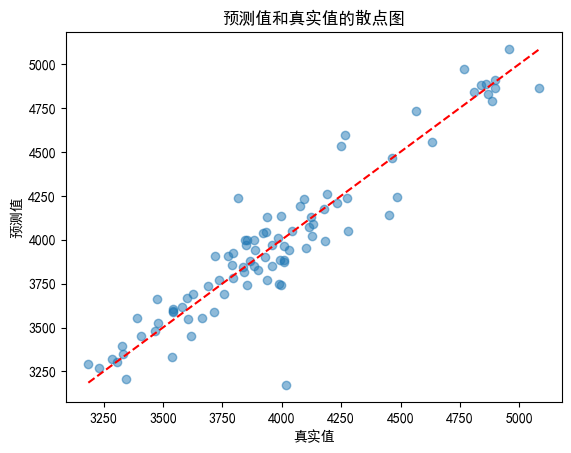

In [68]:
plt.scatter(y_test, y_pred, alpha=0.5) # 绘制预测值和真实值的散点图 // y_test 表示真实值, y_pred 表示预测值
plt.xlabel("真实值") # 添加 x 轴标签
plt.ylabel("预测值") # 添加 y 轴标签
plt.title("预测值和真实值的散点图") # 添加标题
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') # 绘制对角线
plt.show() # 显示图像

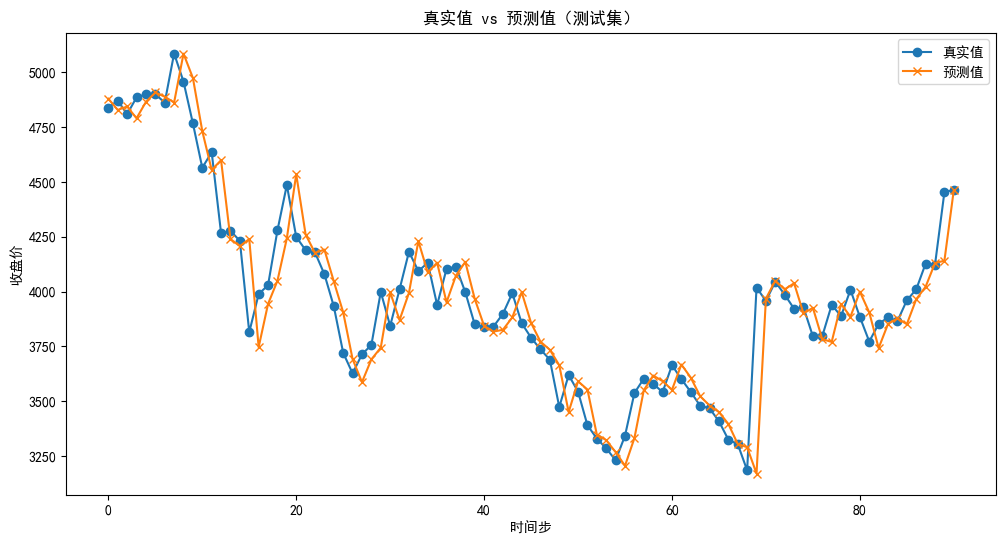

In [69]:
import matplotlib.pyplot as plt

# 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12,6))
plt.plot(y_test, label='真实值', marker='o')
plt.plot(y_pred, label='预测值', marker='x')
plt.title("真实值 vs 预测值（测试集）")
plt.xlabel("时间步")
plt.ylabel("收盘价")
plt.legend()
plt.show()


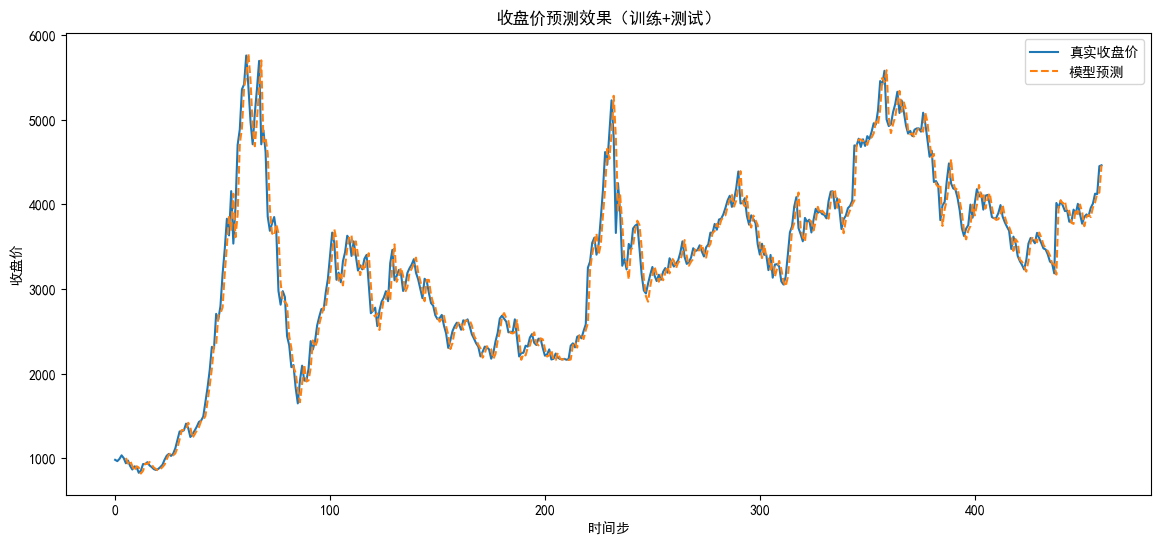

In [70]:
# 拼接预测结果
all_pred = np.empty(len(close_prices))
all_pred[:] = np.nan   # 先填充空值
all_pred[window_size:] = model.predict(X)  # 从第 window_size 天开始才有预测

plt.figure(figsize=(14,6))
plt.plot(close_prices, label="真实收盘价")
plt.plot(all_pred, label="模型预测", linestyle="--")
plt.title("收盘价预测效果（训练+测试）")
plt.xlabel("时间步")
plt.ylabel("收盘价")
plt.legend()
plt.show()


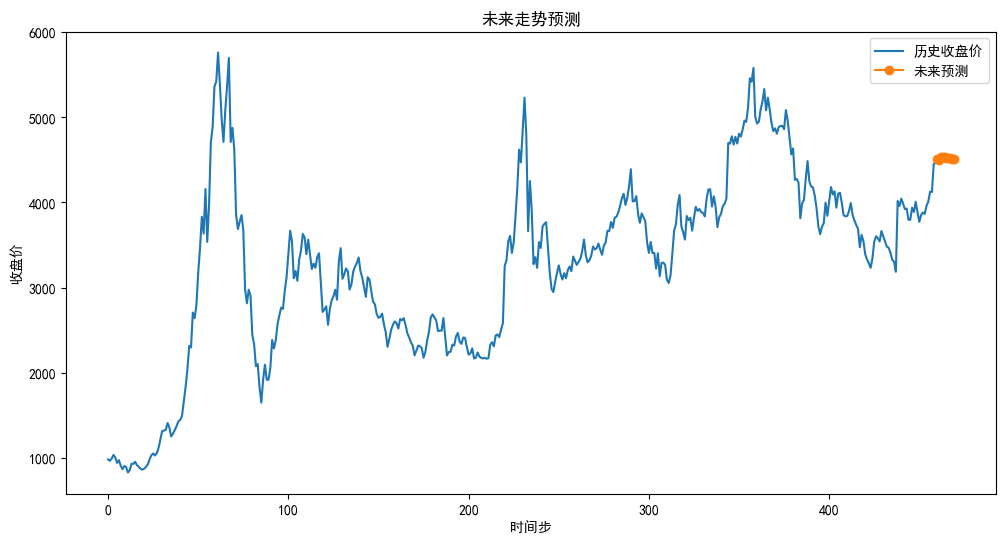

In [71]:
future_days = 10  # 预测未来10天
future_preds = []

last_window = close_prices[-window_size:].copy()
for _ in range(future_days):
    pred = model.predict([last_window])[0]
    future_preds.append(pred)
    # 更新窗口：丢掉最早一天，加上预测值
    last_window = np.append(last_window[1:], pred)

# 可视化：历史 + 未来预测
plt.figure(figsize=(12,6))
plt.plot(range(len(close_prices)), close_prices, label="历史收盘价")
plt.plot(range(len(close_prices), len(close_prices)+future_days),
         future_preds, label="未来预测", marker="o")
plt.title("未来走势预测")
plt.xlabel("时间步")
plt.ylabel("收盘价")
plt.legend()
plt.show()
